In [1]:
%pip install seaborn

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [4]:
# Stil setzen für das gesamte Notebook
sns.set_theme(style="whitegrid")

# Titel: Die Kostenfalle im Schweizer Gesundheitswesen
## From Data to Decisions: Eine strategische Analyse der Spitalfinanzen (2010–2030)


**Studiengang:**   
BSc. Wirtschaftsinformatik   
**Modul:**   
Advanced Statistics for Business Analytics, WI-V-BA002, HS25/26   
**Autor:**   
Daniel Czeczot

---

### Schritt 1: Ausgangslage & Motivation
Das Schweizer Gesundheitswesen steht an einem finanziellen Wendepunkt. Während die Krankenkassenprämien für die Bevölkerung jährlich neue Höchststände erreichen, geraten die Leistungserbringer – insbesondere die Spitäler – zunehmend unter wirtschaftlichen Druck. Die öffentliche Debatte wird oft emotional geführt; was fehlt, ist eine nüchterne, datengestützte Analyse der zugrundeliegenden Treiber.

### Schritt 2: Zielsetzung der Analyse
Diese Projektarbeit untersucht die finanzielle Stabilität der Schweizer Spitäler über einen Zeitraum von 20 Jahren (Historie 2010–2023, Prognose bis 2030). Ziel ist es, mithilfe von statistischen Methoden (Lineare Regression, Ridge-Regularisierung) nicht nur den Status Quo zu beschreiben, sondern zukünftige Risiken zu quantifizieren und strategische Handlungsfelder abzuleiten.

**Die Kernfragen lauten:**
* **Kostentreiber:** Was treibt die Kosten wirklich – Infrastruktur oder Personal?
* **Finanzierungslücke:** Hält die staatliche Finanzierung (GWL) mit der Kostenexplosion Schritt?
* **Prognose 2030:** Wann durchbrechen die Gesamtkosten die kritische 40-Milliarden-Grenze?

### Schritt 3: Datengrundlage (Data Sources)
Die Analyse verknüpft fünf offizielle Datensätze des Bundesamtes für Statistik (BFS), um ein ganzheitliches Bild zu zeichnen:

**A. Die Datenquellen (Data Sources):**
1.  **Finanzstatistik der Spitäler** (`finanzen_spitale.csv`):
    * *Inhalt:* Betriebsaufwand, Erträge und Defizite aller Schweizer Spitäler.
    * *Nutzung:* Trend-Analyse der Kostenexplosion und Rentabilität.

2.  **Gemeinwirtschaftliche Leistungen (GWL)** (`finanzierung_des_gesundheitswesens.csv` - Teil der Finanzstatistik):
    * *Inhalt:* Direkte staatliche Beiträge und Subventionen der Kantone.
    * *Nutzung:* Analyse der politischen Finanzierungsbereitschaft (Volatilität).

3.  **Krankenhausstatistik** (`infrastruktur.csv`):
    * *Inhalt:* Leistungskennzahlen wie Pflegetage, Anzahl Spitäler und Betten.
    * *Nutzung:* Berechnung von Effizienzmetriken (Kosten pro Pflegetag).

4.  **Personalstatistik** (`personal.csv`):
    * *Inhalt:* Beschäftigte in Vollzeitäquivalenten (FTE), unterteilt nach Berufsgruppen (Ärzte, Pflege, Admin).
    * *Nutzung:* Identifikation der Kostentreiber mittels Ridge-Regression.

5.  **Prämienstatistik (KVG)** (`krankenkasse_clean.csv`):
    * *Inhalt:* Entwicklung der mittleren Monatsprämien in der Obligatorischen Krankenpflegeversicherung (OKP).
    * *Nutzung:* Vergleich der Belastung zwischen Prämienzahlern und Steuerzahlern.

**B. Datenaufbereitung (ETL-Prozess):**
Um die Rohdaten analysierbar zu machen, wurde eine automatisierte Pipeline (ETL) entwickelt:
* **Cleaning:** Bereinigung von BFS-Sonderzeichen (z.B. `'`, `...`, `X`) und Typisierung der Zahlenformate.
* **Reshaping:** Transformation der Datensätze vom "Wide-Format" (Jahre als Spalten) in das "Long-Format" (Tidy Data) für Visualisierungen mit Seaborn.
* **Feature Engineering:** Berechnung neuer KPIs wie *CAGR* (Wachstumsrate) und *Kosten pro Pflegetag*.
* **Aggregation:** Zusammenführung der disparaten Quellen auf Ebene "Gesamtschweiz" zur Modellierung globaler Trends.

---

In [5]:
print("--- STARTE DATEN-PIPELINE (ETL) ---")

# 1. HELPER FUNCTIONS
# ------------------------------------------
def clean_string_column(series):
    """Entfernt BFS-Artefakte wie '<<', '...', '-' aus Textspalten"""
    return series.astype(str).str.replace(r'^\s*(<<|\.\.\.\.|-)\s*', '', regex=True).str.strip()

def process_bfs_data(df, id_vars, value_name='Wert'):
    """Wandelt BFS-Tabellen von Wide (Jahre als Spalten) in Long um"""
    if df.empty: return pd.DataFrame()

    # 2024 entfernen falls vorhanden (Daten sind nicht vollstandig)
    if '2024' in df.columns:
        df = df.drop(columns=['2024'])

    # Automatische Erkennung der Jahr-Spalten (2010-2023)
    cols = [str(c).strip() for c in df.columns]
    df.columns = cols # Bereinigte Spaltennamen zuweisen
    value_vars = [c for c in cols if c.isdigit() and 2010 <= int(c) <= 2023]

    # Melt (Transformation zu Long-Format)
    df_long = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='Jahr', value_name=value_name)

    # Cleaning der ID-Spalten (Texte)
    for col in id_vars:
        if col in df_long.columns:
             df_long[col] = clean_string_column(df_long[col])

    # Cleaning der Werte (Zahlen)
    # Entfernt Tausender-Apostrophe und wandelt '...'/'X' in NaN um
    df_long[value_name] = pd.to_numeric(df_long[value_name].astype(str).str.replace("'", ""), errors='coerce')

    # Jahr als Zahl
    df_long['Jahr'] = df_long['Jahr'].astype(int)

    return df_long

--- STARTE DATEN-PIPELINE (ETL) ---


In [6]:
# 2. DATEN LADEN
# ------------------------------------------
# A. Finanzen
df_spit_raw = pd.read_csv(/data/finanzen_spitale.csv', sep=',')

# B. Infrastruktur
df_inf_raw = pd.read_csv('/data/infrastruktur.csv', sep=',')

# C. Personal
df_per_raw = pd.read_csv('/data/personal.csv', sep=',')

# D. Krankenkasse (Prämien)
df_kk_raw = pd.read_csv('/data/krankenkasse.csv', sep=';')

# E. Finanzierungssystem (für Schritt 4d)
df_health_fin = pd.read_csv('/data/finanzierung_des_gesundheitswesens.csv', sep=',')

print ("DATEN LADEN - abgeschlossen")

DATEN LADEN - abgeschlossen


In [7]:
# 3. PROCESSING (TRANSFORMATION)
# ------------------------------------------

# --- Finanzen (Long) ---
id_vars_fin = ['Aufwand und Ertrag', 'Betriebstyp']
# Spaltennamen säubern
df_spit_raw.columns = [str(c).strip() for c in df_spit_raw.columns]
df_spitanzen_clean = process_bfs_data(df_spit_raw, id_vars_fin, value_name='Betrag')

# --- Infrastruktur (Long) ---
id_vars_inf = ['Beobachtungseinheit', 'Grossregion (<<) / Kanton (-)', 'Betriebstyp']
df_inf_clean = process_bfs_data(df_inf_raw, id_vars_inf, value_name='Anzahl')
if 'Grossregion (<<) / Kanton (-)' in df_inf_clean.columns:
    df_inf_clean = df_inf_clean.rename(columns={'Grossregion (<<) / Kanton (-)': 'Region'})

# --- Personal (Long) ---
# Automatische Erkennung der Text-Spalten
id_vars_per = [c for c in df_per_raw.columns if not str(c).strip().isdigit()]
df_per_clean = process_bfs_data(df_per_raw, id_vars_per, value_name='Vollzeitäquivalente')
region_col = [c for c in df_per_clean.columns if 'Grossregion' in c]
if region_col:
    df_per_clean = df_per_clean.rename(columns={region_col[0]: 'Region'})

# --- Krankenkasse (Clean) ---
if not df_kk_raw.empty:
    df_kk_clean = df_kk_raw[df_kk_raw['TIME_PERIOD'].between(2010, 2023)].copy()
    df_kk_clean = df_kk_clean.rename(columns={'TIME_PERIOD': 'Jahr', 'OBS_VALUE': 'Praemien_M_CHF'})
    df_kk_clean = df_kk_clean[['Jahr', 'Praemien_M_CHF']]
else:
    df_kk_clean = pd.DataFrame(columns=['Jahr', 'Praemien_M_CHF'])

print ("PROCESSING - abgeschlossen")

PROCESSING - abgeschlossen


In [8]:
# 4. SPEZIAL-DATENSATZ FÜR SCHRITT 4 & 5 (WIDE FORMAT)
# ------------------------------------------

df_spit = df_spit_raw[
    df_spit_raw['Betriebstyp'].str.contains('Spit', case=False, na=False) &
    df_spit_raw['Betriebstyp'].str.contains('Total', case=False, na=False)
].copy()

# Strings in 'Aufwand und Ertrag' säubern
if 'Aufwand und Ertrag' in df_spit.columns:
    df_spit['Aufwand und Ertrag'] = clean_string_column(df_spit['Aufwand und Ertrag'])

print ("DATENSATZ FÜR SCHRITT 4 & 5 - abgeschlossen")

DATENSATZ FÜR SCHRITT 4 & 5 - abgeschlossen


In [9]:
# 5: AGGREGATIONEN FÜR ANALYSE (KPIs)
# A. Pflegetage
df_pflegetage = df_inf_clean[
    (df_inf_clean['Beobachtungseinheit'] == 'Anzahl Pflegetage') &
    (df_inf_clean['Region'] == 'Schweiz')
].copy()

# B. Anzahl Spitäler
df_spitaeler = df_inf_clean[
    (df_inf_clean['Beobachtungseinheit'] == 'Anzahl Spitäler') &
    (df_inf_clean['Region'] == 'Schweiz')
].copy()

# C. Personal Total
df_personal_kpi = df_per_clean[
    (df_per_clean['Region'] == 'Schweiz') &
    (df_per_clean['Funktion'] == 'Funktion - Total') &
    (df_per_clean['Geschlecht'] == 'Geschlecht - Total')
].copy()

# D. Finanzen Total
target_values = ['Aufwand - Total', 'Ertrag Total', 'Ertrag - Total']

df_spitanzenanz_total = df_spitanzen_clean[
    (df_spitanzen_clean['Betriebstyp'] == 'Spitäler - Total') &
    (df_spitanzen_clean['Aufwand und Ertrag'].isin(target_values))
].copy()

# Berechnung der Millionen-Spalte für das Diagramm
df_spitanzenanz_total['Betrag_Mio'] = df_spitanzenanz_total['Betrag'] / 1e6

print ("AGGREGATIONEN FÜR ANALYSE (KPIs) - abgeschlossen")
print ("Pipeline erfolgreich durchlaufen.")

AGGREGATIONEN FÜR ANALYSE (KPIs) - abgeschlossen
Pipeline erfolgreich durchlaufen.


### Schritt 4a: Descriptive Analytics (Status Quo Analyse)

Bevor ich Algorithmen einsetze, verschaffe ich mir einen Überblick über die "Geschichte" der Daten. Ich analysiere vier Dimensionen:
1.  **Nachfrage:** Wie entwickeln sich die Pflegetage?
2.  **Ressourcen:** Wie entwickelt sich der Personalbestand?
3.  **Finanzen:** Decken die Erträge den Aufwand?
4.  **Konsequenz:** Wie reagieren die Krankenkassenprämien?

In [10]:
# --- A. Pflegetage ---
df_pflegetage = df_inf_clean[
    (df_inf_clean['Beobachtungseinheit'] == 'Anzahl Pflegetage') &
    (df_inf_clean['Region'] == 'Schweiz')
].copy()

# --- B. Personal ---
df_personal_kpi = df_per_clean[
    (df_per_clean['Region'] == 'Schweiz') &
    (df_per_clean['Funktion'] == 'Funktion - Total') &
    (df_per_clean['Geschlecht'] == 'Geschlecht - Total') &
    (df_per_clean['Staatsangehörigkeit (Auswahl)'] == 'Staatsangehörigkeit - Total') &
    (df_per_clean['Anzahl Personen'] == 'Internes Personal per Ende Jahr')
].copy()

# --- C. Finanzen ---
df_spitanzen_clean = df_spitanzen_clean.copy()
df_spitanzen_clean['Betrag'] = df_spitanzen_clean['Betrag'].fillna(0)

df_spitanzenanz_total = df_spitanzen_clean[
    (df_spitanzen_clean['Betriebstyp'] == 'Spitäler - Total') &
    (df_spitanzen_clean['Aufwand und Ertrag'].isin(['Aufwand - Total', 'Ertrag Total']))
].copy()

df_spitanzenanz_total['Betrag_Mio'] = df_spitanzenanz_total['Betrag'] / 1_000_000


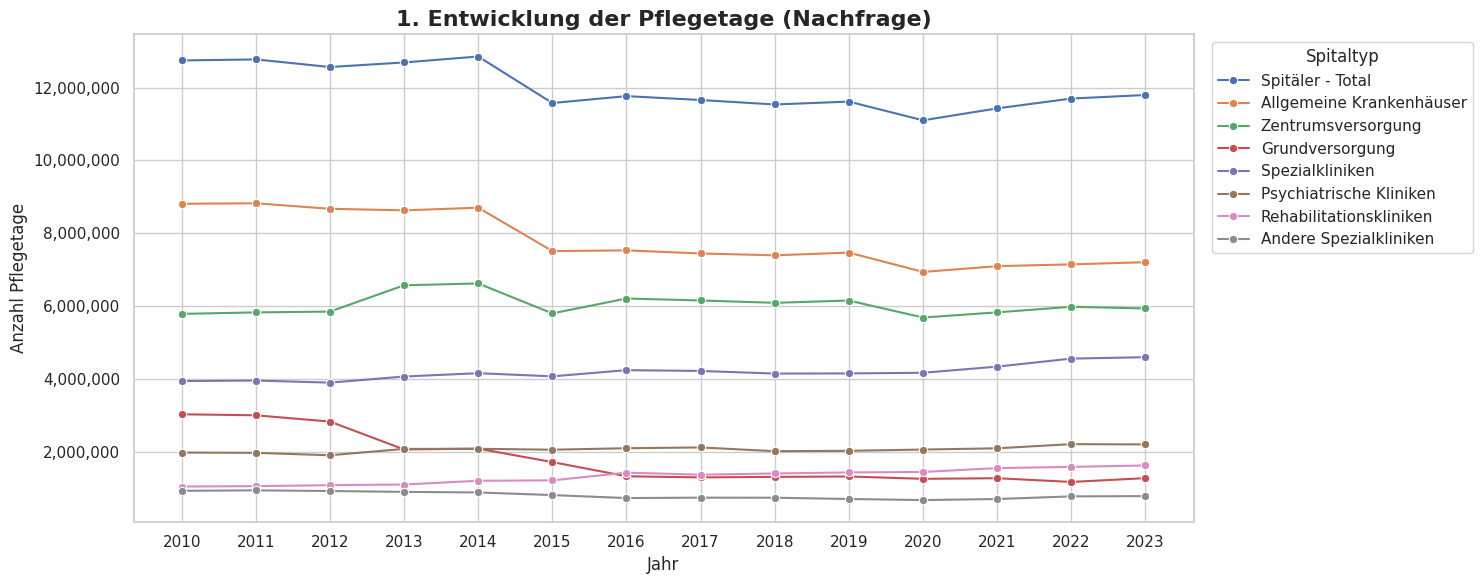

In [11]:
# Grafik 1
plt.figure(figsize=(15, 6)) # Eigene Figur für diesen Plot
ax = sns.lineplot(data=df_pflegetage, x='Jahr', y='Anzahl', hue='Betriebstyp', marker='o')

ax.set_title('1. Entwicklung der Pflegetage (Nachfrage)', fontsize=16, fontweight='bold')
ax.set_ylabel('Anzahl Pflegetage', fontsize=12)

# Formatierung
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.legend(title='Spitaltyp', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Interpretation Grafik 1 (Nachfrage):**
Die Kurve zeigt eine Stagnation. Trotz Bevölkerungswachstum bleiben die stationären Pflegetage flach oder leicht rückläufig. Das bedeutet: Die "Arbeitsmenge" am Patienten ist nicht explodiert.

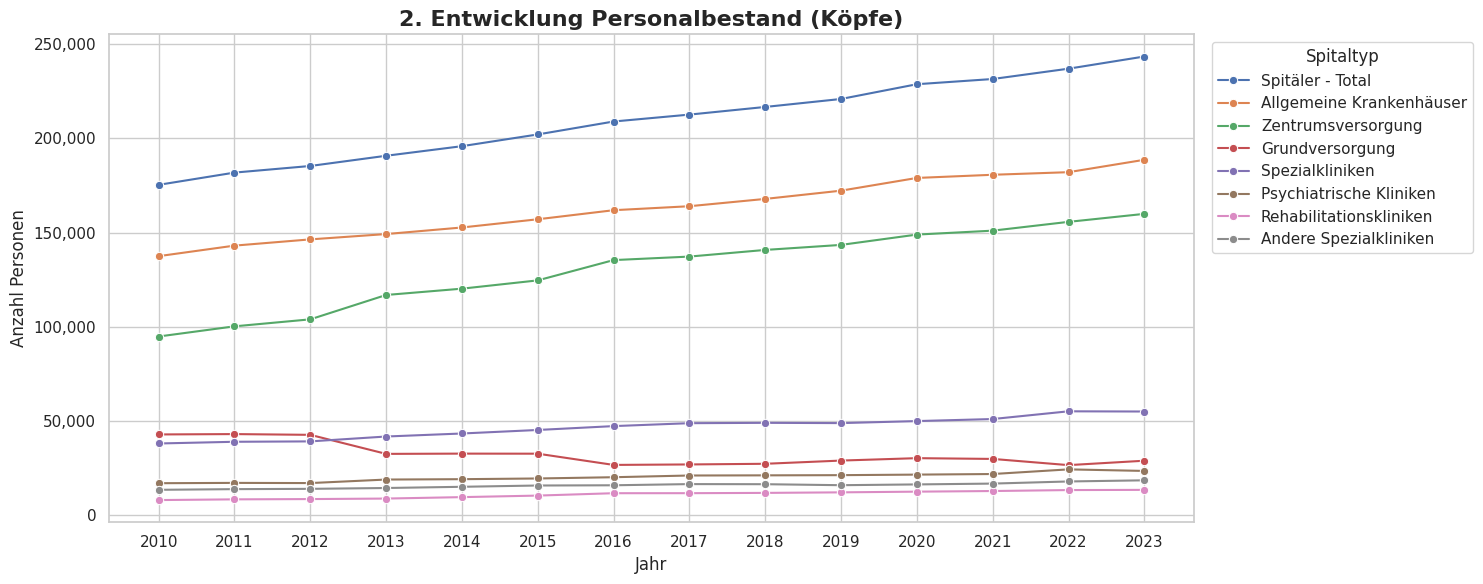

In [12]:
# Grafik 2
plt.figure(figsize=(15, 6))
ax = sns.lineplot(data=df_personal_kpi, x='Jahr', y='Vollzeitäquivalente', hue='Betriebstyp', marker='o')

ax.set_title('2. Entwicklung Personalbestand (Köpfe)', fontsize=16, fontweight='bold')
ax.set_ylabel('Anzahl Personen', fontsize=12)

# Formatierung
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.legend(title='Spitaltyp', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Interpretation Grafik 2 (Ressourcen):**
Im krassen Gegensatz zur Nachfrage zeigt die Personalkurve steil nach oben. Wir leisten uns immer mehr Personal für die gleiche Menge an Patienten.

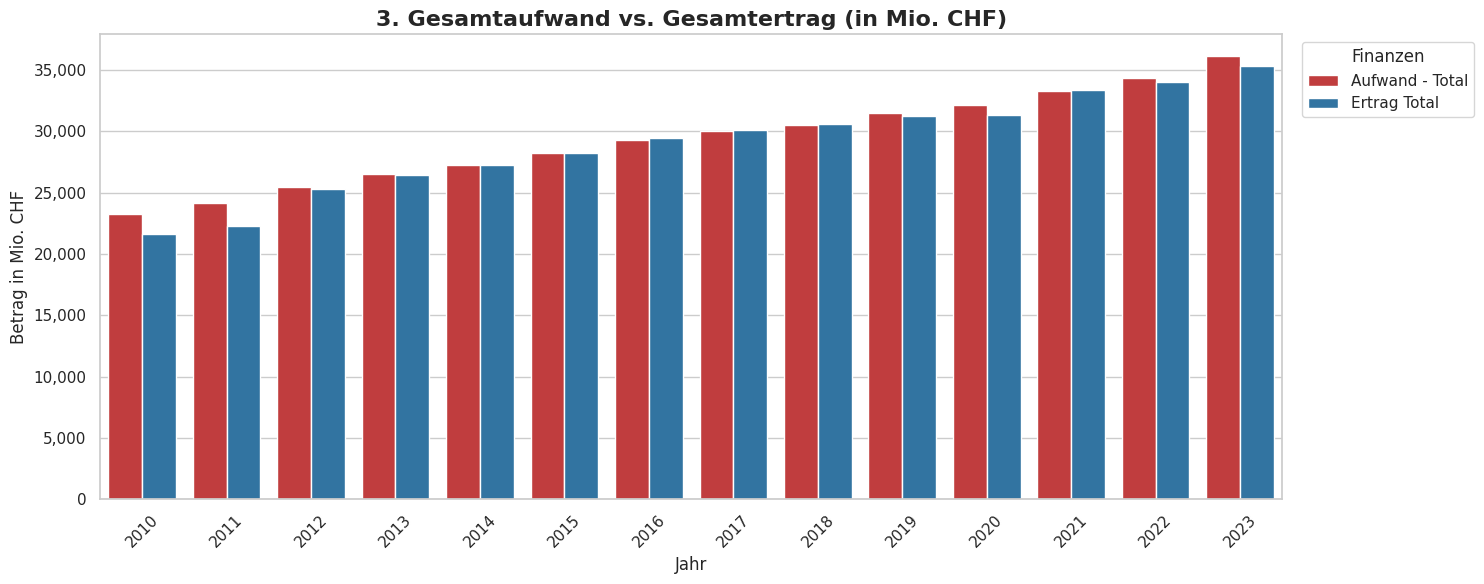

In [13]:
# Grafik 3
plt.figure(figsize=(15, 6))
colors = {"Aufwand - Total": "#d62728", "Ertrag Total": "#1f77b4"}

ax = sns.barplot(data=df_spitanzenanz_total, x='Jahr', y='Betrag_Mio', hue='Aufwand und Ertrag', palette=colors)

ax.set_title('3. Gesamtaufwand vs. Gesamtertrag (in Mio. CHF)', fontsize=16, fontweight='bold')
ax.set_ylabel('Betrag in Mio. CHF', fontsize=12)

# Formatierung
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(title='Finanzen', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Interpretation Grafik 3 (Finanzlage):**
Die Kosten (rot) fressen die Erträge (blau) fast vollständig auf. Die Margen sind extrem dünn, das System hat keine finanziellen Reserven.

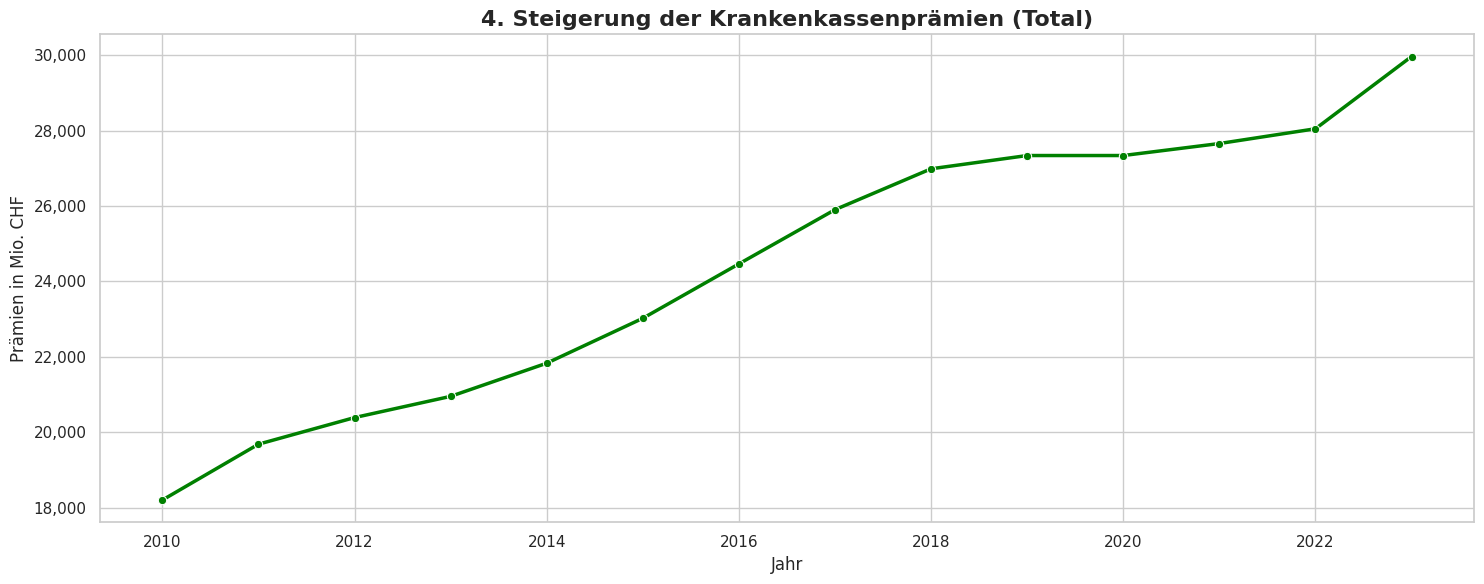

In [14]:
# Grafik 4
plt.figure(figsize=(15, 6))
ax = sns.lineplot(data=df_kk_clean, x='Jahr', y='Praemien_M_CHF', color='green', marker='o', linewidth=2.5)

ax.set_title('4. Steigerung der Krankenkassenprämien (Total)', fontsize=16, fontweight='bold')
ax.set_ylabel('Prämien in Mio. CHF', fontsize=12)

# Formatierung
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

**Interpretation Grafik 4 (Konsequenz):**
Dies ist die "Rechnung" für den Bürger. Da die Kosten durch den Personalaufbau steigen, müssen die Krankenkassenprämien (grüne Linie) zwangsläufig nach oben angepasst werden, um das System zu finanzieren.

In [15]:
print("--- TREIBER-ANALYSE ---")

# 1. Definitionen
categories = {
    'Ärzteschaft': 'Ärzte',
    'Pflegepersonal': 'Pflege',
    'Administrativpersonal': 'Administration',
    'Medizinisch - technisches Personal': 'MedTech',
    'Medizinisch - therapeutisches Personal': 'Therapie',
    'Hausdienstpersonal': 'Hausdienst',
    'Technische Dienste': 'Technik',
    'Sozialdienste': 'Sozialdienst'
}

# 2. Daten zusammenführen
df_drivers = pd.DataFrame({'Jahr': range(2010, 2024)})

# Personal-Daten mergen
for cat_bfs, cat_name in categories.items():
    temp = df_per_clean[
        (df_per_clean['Region'] == 'Schweiz') &
        (df_per_clean['Betriebstyp'] == 'Spitäler - Total') &
        (df_per_clean['Funktion'] == cat_bfs) &
        (df_per_clean['Anzahl Personen'] == 'Internes Personal per Ende Jahr')
    ]
    if not temp.empty:
        data = temp.set_index('Jahr')['Vollzeitäquivalente'].rename(cat_name)
        df_drivers = df_drivers.merge(data, on='Jahr', how='left')

# Kosten-Daten mergen
costs = df_spitanzen_clean[
    (df_spitanzen_clean['Betriebstyp'] == 'Spitäler - Total') &
    (df_spitanzen_clean['Aufwand und Ertrag'] == 'Aufwand - Total')
].set_index('Jahr')['Betrag'].rename('Gesamtkosten')

df_drivers = df_drivers.merge(costs, on='Jahr', how='inner').dropna()

# 3. Index setzen
df_drivers = df_drivers.set_index('Jahr')


--- TREIBER-ANALYSE ---


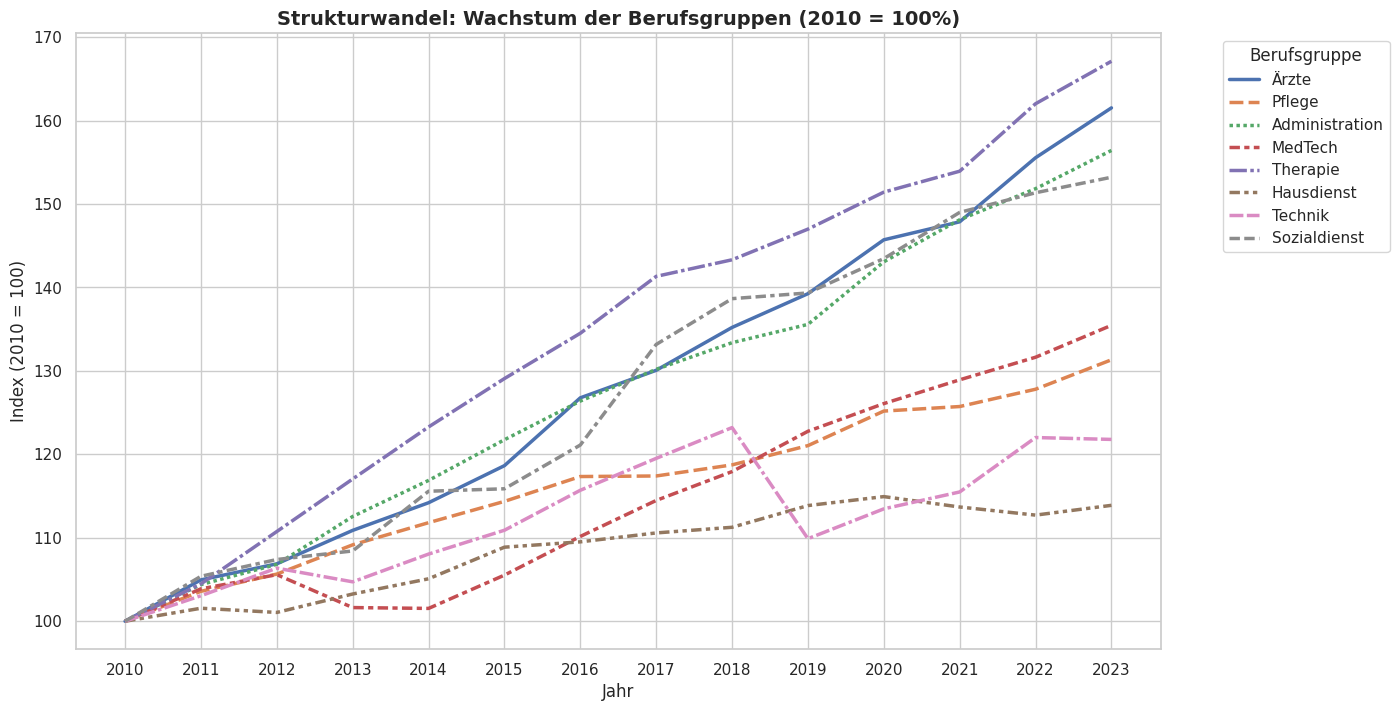

In [16]:
# Grafik - Strukturwandel
# Berechnung der indexierten Werte
df_indexed = df_drivers.div(df_drivers.iloc[0]) * 100
df_indexed = df_indexed.drop(columns=['Gesamtkosten'])

# Plotten
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_indexed, linewidth=2.5)

plt.title('Strukturwandel: Wachstum der Berufsgruppen (2010 = 100%)', fontsize=14, fontweight='bold')
plt.ylabel('Index (2010 = 100)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Berufsgruppe')
plt.xticks(df_indexed.index)
plt.grid(True)
plt.show()

**2. Statistische Diagnose (Heatmap):**
Die Heatmap zeigt ein Problem: Fast alle Felder sind tiefrot. Das bedeutet, dass *alle* Berufsgruppen extrem stark mit den Kosten korrelieren (Multikollinearität).
* **Konsequenz:** Eine einfache Regression würde scheitern, da sie nicht unterscheiden kann, wer der wahre Kostentreiber ist.

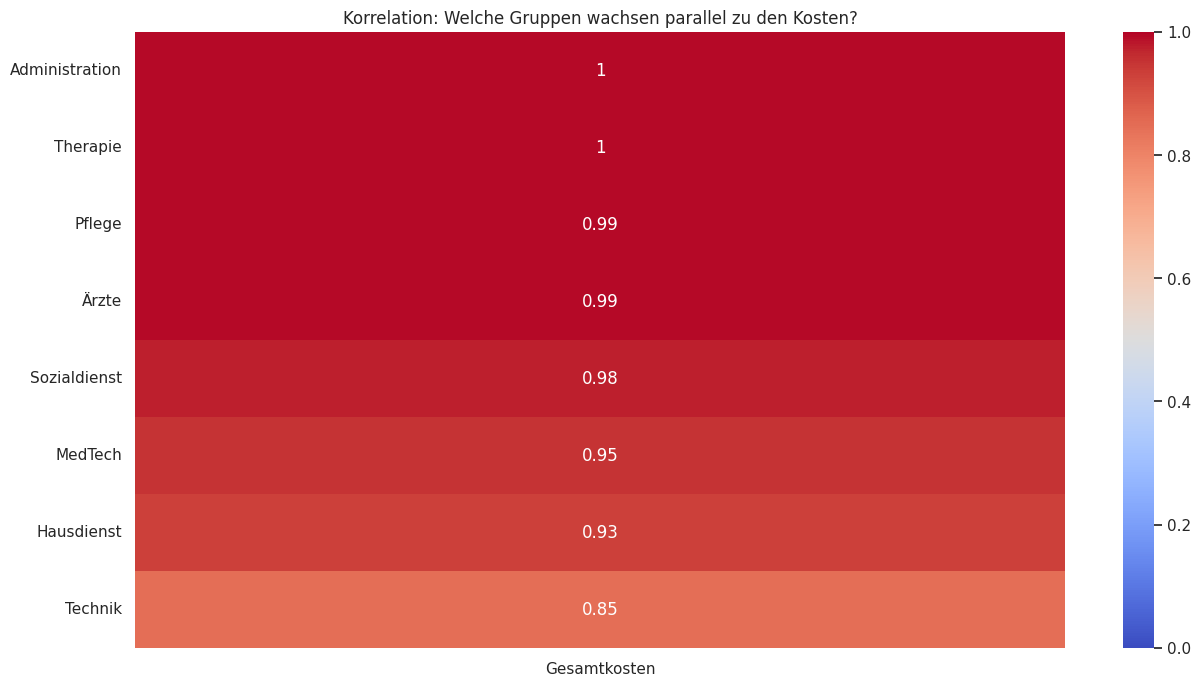

In [17]:
# Grafik - Korrelation (Heatmap)
plt.figure(figsize=(15, 8))

# Korrelation berechnen
corr_matrix = df_drivers.corr()[['Gesamtkosten']].sort_values(by='Gesamtkosten', ascending=False)
corr_matrix = corr_matrix.drop('Gesamtkosten')

# Plotten
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Korrelation: Welche Gruppen wachsen parallel zu den Kosten?')
plt.show()

### Schritt 4b: Diagnostic Analytics – Die Treiber-Analyse

**Frage:** Welche Faktoren treiben die Kosten wirklich? Ist es einfach nur "mehr Personal" oder verändert sich die Struktur?

Um dies objektiv zu beantworten, nutzen wir einen **Machine-Learning-Ansatz (Ridge Regression)**.

* **Das Problem:** Wenn wir einfach nur Korrelationen messen, scheint *alles* mit den Kosten zu steigen (weil das Gesundheitswesen generell wächst). Das nennt man *Multikollinearität*.
* **Die Lösung (Ridge Regression):** Dieses statistische Verfahren "bestraft" das Modell für Überanpassung. Es zwingt das Modell, sich zu entscheiden, welche Variablen *wirklich* die erklärende Kraft besitzen und welche nur "mitlaufen".
* **Das Ziel:** Wir erhalten eine **"Feature Importance"**, also ein Ranking, das uns zeigt, welche Berufsgruppe pro Vollzeitstelle den stärksten Hebel auf die Gesamtkosten ausübt.

Bestes gefundenes Alpha: 0.1
R² Score des Modells: 0.9971


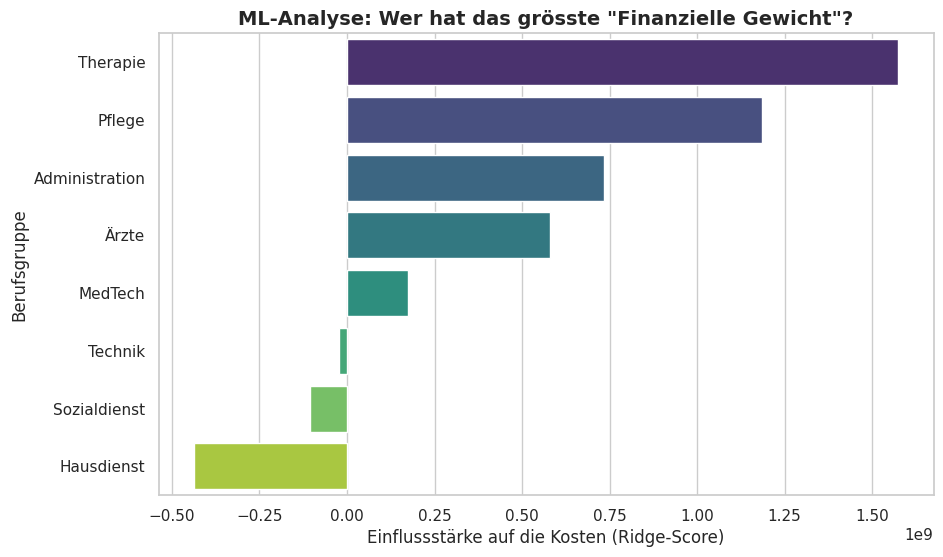

In [18]:
# Machine Learning (Ridge Regression & Plot)
from sklearn.linear_model import RidgeCV
# A. Daten vorbereiten für ML
X = df_drivers.drop(columns=['Gesamtkosten'])
y = df_drivers['Gesamtkosten']

# Skalierung (Wichtig für Ridge)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# B. Modell trainieren & Alpha finden
# Wir geben eine Liste von Alphas an, die getestet werden sollen (logarithmische Skala ist üblich)
alphas_to_test = [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0]

# RidgeCV führt automatisch eine Cross-Validation für diese Werte durch
model_ridge = RidgeCV(alphas=alphas_to_test, scoring='neg_mean_squared_error')
model_ridge.fit(X_scaled, y)

# Den Gewinner ausgeben
print(f"Bestes gefundenes Alpha: {model_ridge.alpha_}")
print(f"R² Score des Modells: {model_ridge.score(X_scaled, y):.4f}")

# C. Ergebnisse extrahieren
importance = pd.DataFrame({
    'Berufsgruppe': X.columns,
    'Einfluss (Ridge-Score)': model_ridge.coef_
}).sort_values(by='Einfluss (Ridge-Score)', ascending=False)

# D. Plotten (Mit Fix für die Warnung)
plt.figure(figsize=(10, 6))

sns.barplot(
    data=importance,
    x='Einfluss (Ridge-Score)',
    y='Berufsgruppe',
    hue='Berufsgruppe',
    palette='viridis',
    legend=False
)

plt.title('ML-Analyse: Wer hat das grösste "Finanzielle Gewicht"?', fontsize=14, fontweight='bold')
plt.xlabel('Einflussstärke auf die Kosten (Ridge-Score)')
plt.show()

In [19]:
print("--- ML ERGEBNIS TABELLE ---")
display(importance.set_index('Berufsgruppe'))

--- ML ERGEBNIS TABELLE ---


,Einfluss (Ridge-Score)
Berufsgruppe,
Therapie,1.575194e+09
Pflege,1.185338e+09
Administration,7.349627e+08
Ärzte,5.791437e+08
MedTech,1.755736e+08
Technik,-2.398955e+07
Sozialdienst,-1.066187e+08
Hausdienst,-4.374723e+08


**Interpretation der ML-Ergebnisse:**

Die Machine-Learning-Analyse (Ridge Regression) bestätigt, dass die Entwicklung der Personalkosten der dominierende Faktor für die Gesamtkosten ist ($R^2 > 99\%$). Viel spannender ist jedoch die **Gewichtung der einzelnen Berufsgruppen** (Feature Importance), die aufzeigt, *welche* Bereiche die Kostenexplosion primär treiben:

1.  **Top-Treiber: Medizinisch-therapeutisches Personal**
    Überraschenderweise identifiziert das Modell das therapeutische Personal (Physiotherapie, Ergotherapie etc.) als den stärksten Einflussfaktor (höchster Ridge-Score). Ein Blick auf die Daten erklärt warum: Diese Gruppe verzeichnete mit **+67%** (2010–2023) das stärkste Wachstum aller Kategorien. Dies deutet auf eine massive Ausweitung von spezialisierten Therapieleistungen und Rehabilitation hin, die ein wesentlicher Kostentreiber sind.

2.  **Die "Bürokratie-Hypothese": Administration auf Platz 3**
    Das administrative Personal wird als dritthäufigster Kostentreiber identifiziert. Besonders brisant: Das Wachstum dieser Gruppe (**+56%**) verläuft fast synchron zum Anstieg der Gesamtkosten (**+55%**). Dies untermauert die These der zunehmenden Bürokratisierung: Der Verwaltungsapparat wächst praktisch 1:1 mit jedem Franken, der mehr ausgegeben wird.

3.  **Pflege als Basisfaktor – aber nicht als Wachstumsmotor**
    Das Pflegepersonal hat zwar als grösste Berufsgruppe ein hohes finanzielles Gewicht (Platz 2), wuchs aber im Vergleich "nur" um **+31%**. Das bedeutet: Die Kostenexplosion wird **strukturell** weniger durch "mehr Hände am Bett" getrieben, sondern viel stärker durch die **Spezialisierung** (Therapie, Ärzte +61%) und den **Verwaltungsaufwand**.

**Fazit:** Das Modell entlarvt eine strukturelle Verschiebung. Das Schweizer Gesundheitswesen wird nicht einfach nur "grösser", es wird **komplexer (Therapie/Spezialisierung)** und **administrativer**.

### Schritt 4c: Predictive Analytics (Prognose 2030)
#### Der Blick in die Zukunft: Wann fällt die 40-Milliarden-Grenze?

Nach der Analyse des Ist-Zustands (deskriptiv) wechsle ich nun zur **prädiktiven Analyse**. Ziel ist es, auf Basis der historischen Datenreihe (2010–2023) die Kostenentwicklung bis zum Jahr 2030 zu modellieren.

#### Methodik & Modellwahl
* **Modell:** Lineare Regression (OLS).
* **Begründung:** Obwohl die Kostenkurve 2023 einen starken Sprung (+1.7 Mrd.) zeigte, wäre ein polynomisches Modell (kurvig) riskant ("Overfitting"). Es würde den einmaligen Sprung als Beginn eines exponentiellen Wachstums interpretieren. Das lineare Modell ist konservativer und robuster gegenüber kurzfristigen Ausreissern.
* **Datenbasis:** Bereinigte Gesamtaufwände der Kategorie "Spitäler - Total" (BFS).

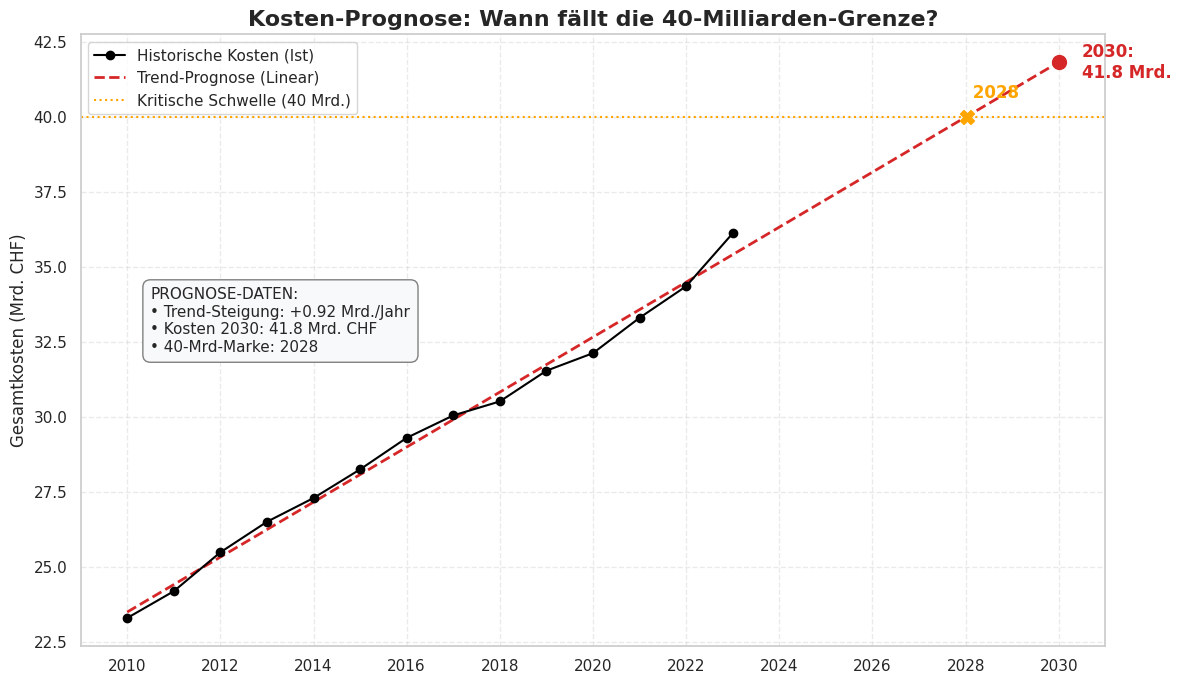

In [20]:
# ==========================================
# SCHRITT 4c: Predictive Analytics (Prognose 2030)
# ==========================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# 1. SETUP & DATEN

cols_years = [str(y) for y in range(2010, 2024)]

# Helper für Zahlen-Cleaning
def clean_money(val):
    return float(str(val).replace("'", "").replace("...", "nan"))

# Daten extrahieren
df_cost = df_spit[
    df_spit['Aufwand und Ertrag'].str.contains('Aufwand - Total', na=False)
]

# Zeitreihen erstellen
y_hist = np.array([clean_money(x) for x in df_cost[cols_years].values[0]]) / 1e9
X_hist = np.array([int(y) for y in cols_years]).reshape(-1, 1)

# 2. MODELLIERUNG (Lineare Regression)
# ------------------------------------------
model = LinearRegression()
model.fit(X_hist, y_hist)

years_future = np.arange(2010, 2031).reshape(-1, 1)
y_pred = model.predict(years_future)

# 3. KENNZAHLEN BERECHNEN
# ------------------------------------------
# Exakter Schnittpunkt mit 40 Mrd.
slope = model.coef_[0]
intercept = model.intercept_
exact_cross_year = (40 - intercept) / slope
cross_year_int = int(np.ceil(exact_cross_year))

val_2030 = y_pred[-1]
# CAGR (Compound Annual Growth Rate)
cagr = ((y_hist[-1] / y_hist[0])**(1/len(y_hist)) - 1) * 100

# 4. PLOTTING
# ------------------------------------------
fig, ax = plt.subplots(figsize=(12, 7))

# Kurven
ax.plot(X_hist, y_hist, 'o-', color='black', label='Historische Kosten (Ist)', zorder=5)
ax.plot(years_future, y_pred, color='#d62728', linestyle='--', linewidth=2, label='Trend-Prognose (Linear)')

ax.axhline(y=40, color='orange', linestyle=':', linewidth=1.5, label='Kritische Schwelle (40 Mrd.)')

# Highlight Schnittpunkt
if 2010 <= exact_cross_year <= 2030:
    ax.scatter(exact_cross_year, 40, color='orange', s=100, zorder=6, marker='X')
    ax.text(exact_cross_year, 40.5, f" {int(exact_cross_year)}", color='orange', fontweight='bold', va='bottom')

# Highlight 2030
ax.scatter(2030, val_2030, color='#d62728', s=100, zorder=6)
ax.text(2030.5, val_2030, f"2030:\n{val_2030:.1f} Mrd.", color='#d62728', fontweight='bold', va='center')

# Styling
plt.title(f'Kosten-Prognose: Wann fällt die 40-Milliarden-Grenze?', fontsize=16, fontweight='bold')
plt.ylabel('Gesamtkosten (Mrd. CHF)', fontsize=12)
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(np.arange(2010, 2031, 2))

# Info-Box
stats_text = (
    f"PROGNOSE-DATEN:\n"
    f"• Trend-Steigung: +{slope:.2f} Mrd./Jahr\n"
    f"• Kosten 2030: {val_2030:.1f} Mrd. CHF\n"
    f"• 40-Mrd-Marke: {int(exact_cross_year)}"
)
plt.text(2010.5, y_hist.max()*0.95, stats_text, fontsize=11,
         ha='left', va='top',
         bbox=dict(facecolor='#f8f9fa', edgecolor='gray', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


#### Kernergebnisse der Prognose
Die Projektion zeigt einen ungebrochenen Aufwärtstrend:
1.  **Die 40-Milliarden-Schwelle:** Das Modell prognostiziert, dass die Gesamtkosten der Schweizer Spitäler im Jahr **2028** die Marke von 40 Milliarden CHF durchbrechen werden.
2.  **Zielwert 2030:** Bis zum Ende der Dekade steigen die Kosten auf voraussichtlich **42 Milliarden CHF**.

### Schritt 4d: Die Finanzierungs-Analyse (Kontext)
#### Die "Black Box" der Geldströme: Wer zahlt wirklich?

Eine reine Kostenbetrachtung greift zu kurz. Entscheidend ist, wer diese Kosten trägt. Die BFS-Statistik weist zwar "Beiträge von Kantonen" aus (~ 2.5 Mrd.), doch dies sind nur die direkten Subventionen (GWL).
Der Grossteil der Staatsgelder (ca. 10-12 Mrd.) fliesst versteckt über die **Fallpauschalen (55%-Anteil)** und ist in der Position "Erträge aus Leistungen" (~30 Mrd.) unsichtbar verbucht.

#### Vorgehen: Rekonstruktion
Um Transparenz zu schaffen, habe ich ein **Rekonstruktions-Modell** entwickelt, das diese versteckten Flüsse sichtbar macht:
1.  **Kantonsanteil (55%):** Wurde aus den stationären Umsätzen herausgerechnet und dem Staat zugewiesen.
2.  **IPV (Prämienverbilligung):** Wurde basierend auf der Staatsquote der OKP isoliert.

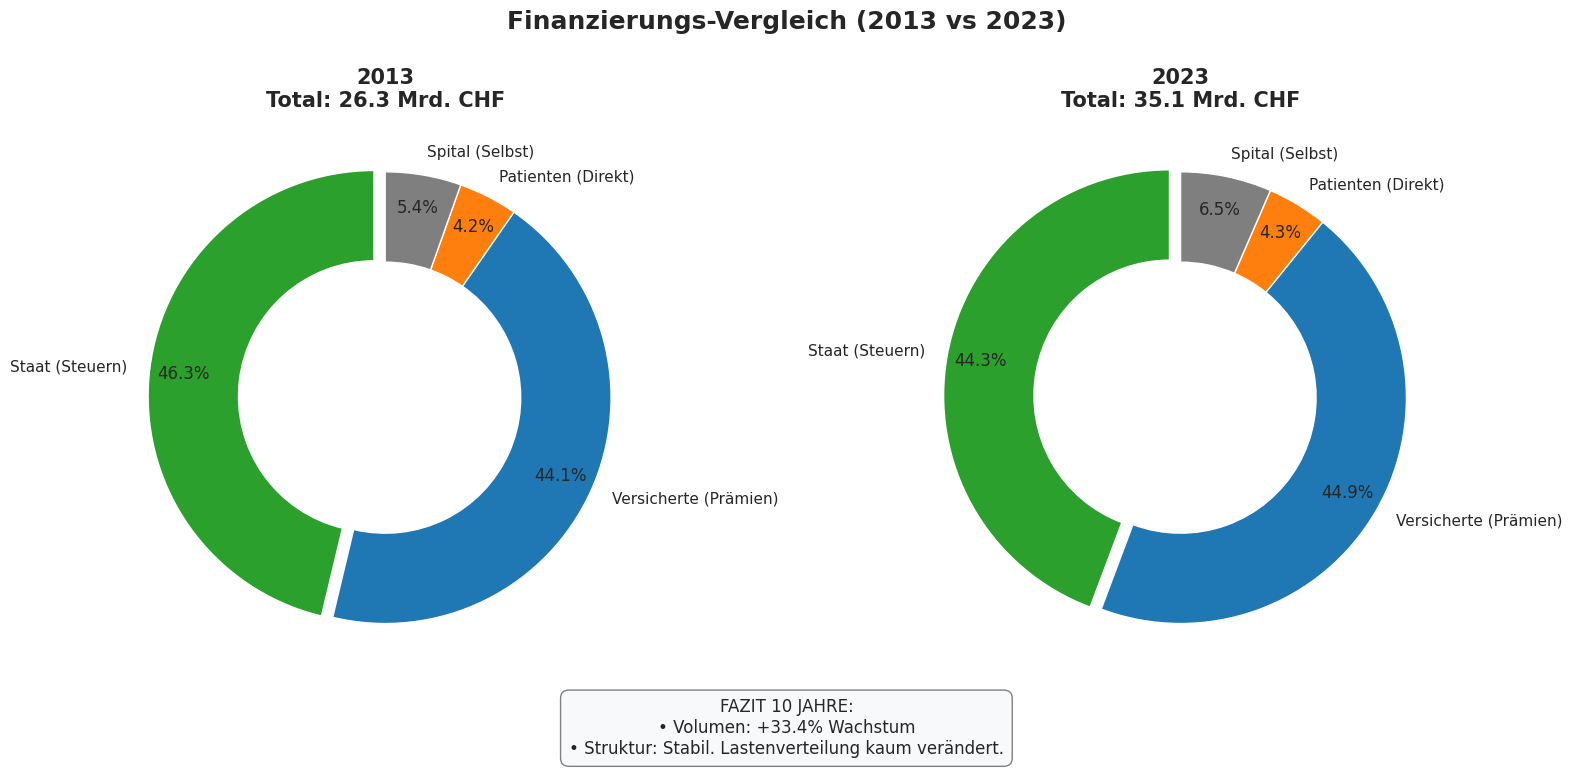

In [21]:
# --- 1. MODELL-BERECHNUNG (2013 vs 2023) ---
def get_funding_mix(year):
    col = str(year)

    if col not in df_spit.columns:
        return None, 0

    def get_val(filter_mask):
        val_series = df_spit[filter_mask][col]
        if len(val_series) == 0: return 0.0
        # Cleaning
        val_str = str(val_series.values[0])
        val_clean = float(val_str.replace("'", "").replace("...", "nan"))
        return val_clean / 1e9

    # 1. Leistungsumsatz
    val_leistung = get_val(df_spit['Aufwand und Ertrag'] == '< Erträge aus Leistungen an Patienten')

    # 2. Direkte Subventionen
    val_subs = get_val(df_spit['Aufwand und Ertrag'] == '.. Beiträge von Kantonen')

    # 3. Selbstfinanzierung (Summe mehrerer Kategorien)
    mask_self = df_spit['Aufwand und Ertrag'].isin([
        '< Finanzertrag',
        '< Erträge aus Leistungen an Personal und Dritte',
        '< Steuern, ausserordentlicher und betriebsfremder Ertrag'
    ])
    # Summe manuell bilden
    vals_self = df_spit[mask_self][col].astype(str).str.replace("'", "").str.replace("...", "0")
    val_self = pd.to_numeric(vals_self, errors='coerce').sum() / 1e9

    # B. Verteilschlüssel OKP
    df_hf_year = df_health_fin[df_health_fin['TIME_PERIOD'] == int(year)]
    okp_total = df_hf_year[df_hf_year['Financing scheme'] == 'Compulsory health insurance']['OBS_VALUE'].sum()
    okp_state = df_hf_year[(df_hf_year['Financing scheme'] == 'Compulsory health insurance') &
                           (df_hf_year['Financing source'].isin(['Cantons', 'Confederation']))]['OBS_VALUE'].sum()

    ratio_ipv = okp_state / okp_total if okp_total > 0 else 0.16

    # C. Rekonstruktion
    est_canton_share = val_leistung * 0.70 * 0.55
    est_patient = val_leistung * 0.05
    pot_insurance = val_leistung - est_canton_share - est_patient

    est_ipv = pot_insurance * ratio_ipv
    est_prem = pot_insurance * (1 - ratio_ipv)

    # Summen
    final_state = val_subs + est_canton_share + est_ipv
    final_prem = est_prem
    final_patient = est_patient
    final_self = val_self

    return [final_state, final_prem, final_patient, final_self], (val_leistung + val_subs + val_self)

# Werte berechnen
sizes_13, total_13 = get_funding_mix(2013)
sizes_23, total_23 = get_funding_mix(2023)

# --- 2. PLOTTING ---
if total_13 > 0 and total_23 > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    labels = ['Staat (Steuern)', 'Versicherte (Prämien)', 'Patienten (Direkt)', 'Spital (Selbst)']
    colors = ['#2ca02c', '#1f77b4', '#ff7f0e', '#7f7f7f']
    explode = (0.05, 0, 0, 0)

    ax1.pie(sizes_13, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, pctdistance=0.85, wedgeprops={'width': 0.4, 'edgecolor': 'white'})
    ax1.set_title(f"2013\nTotal: {total_13:.1f} Mrd. CHF", fontsize=15, fontweight='bold')

    ax2.pie(sizes_23, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, pctdistance=0.85, wedgeprops={'width': 0.4, 'edgecolor': 'white'})
    ax2.set_title(f"2023\nTotal: {total_23:.1f} Mrd. CHF", fontsize=15, fontweight='bold')

    plt.suptitle('Finanzierungs-Vergleich (2013 vs 2023)', fontsize=18, fontweight='bold')

    growth = (total_23 / total_13 - 1) * 100
    info = f"FAZIT 10 JAHRE:\n• Volumen: +{growth:.1f}% Wachstum\n• Struktur: Stabil. Lastenverteilung kaum verändert."
    plt.figtext(0.5, 0.05, info, ha='center', fontsize=12, bbox=dict(facecolor='#f8f9fa', edgecolor='gray', boxstyle='round,pad=0.5'))

    plt.tight_layout(rect=[0, 0.12, 1, 0.95])
    plt.show()
else:
    print("Fehler: Konnte Daten für 2013 oder 2023 nicht extrahieren. Prüfen Sie die Spaltennamen in 'finanzen_spitale.csv'.")

#### Erkenntnis aus dem 10-Jahres-Vergleich (2013 vs 2023)
* **Volumen-Explosion:** Die Gesamtkosten sind massiv gestiegen.
* **Strukturelle Starre:** Die Anteile (Tortenstücke) haben sich kaum verschoben. Der Staat hat es nicht geschafft, die Prämienzahler relativ zu entlasten – er zahlt einfach "seinen fixen Anteil" an einem immer teureren System.

### Schritt 4e: Quality Check & Validierung
#### Statistische Überprüfung der Prognosemodelle

Im Sinne einer sorgfältigen Datenanalyse ("Due Diligence") werden die verwendeten Prognosemodelle im letzten Schritt validiert. Ziel ist es, die Verlässlichkeit der getroffenen Vorhersagen zu quantifizieren.
Um die unterschiedlichen Modelle vergleichbar zu machen, werden die Abweichungen (Residuen) auf einer **einheitlichen Skala (-17% bis +17%)** visualisiert.

**Verwendete Metriken:**
* **$R^2$ (Bestimmtheitsmass):** Gibt an, wie gut das Modell den historischen Trend abbildet.
* **Residuen (Relativer Fehler):** Zeigt die prozentuale Abweichung zwischen Modell und Realität pro Jahr.

--- START QUALITY CHECK ---


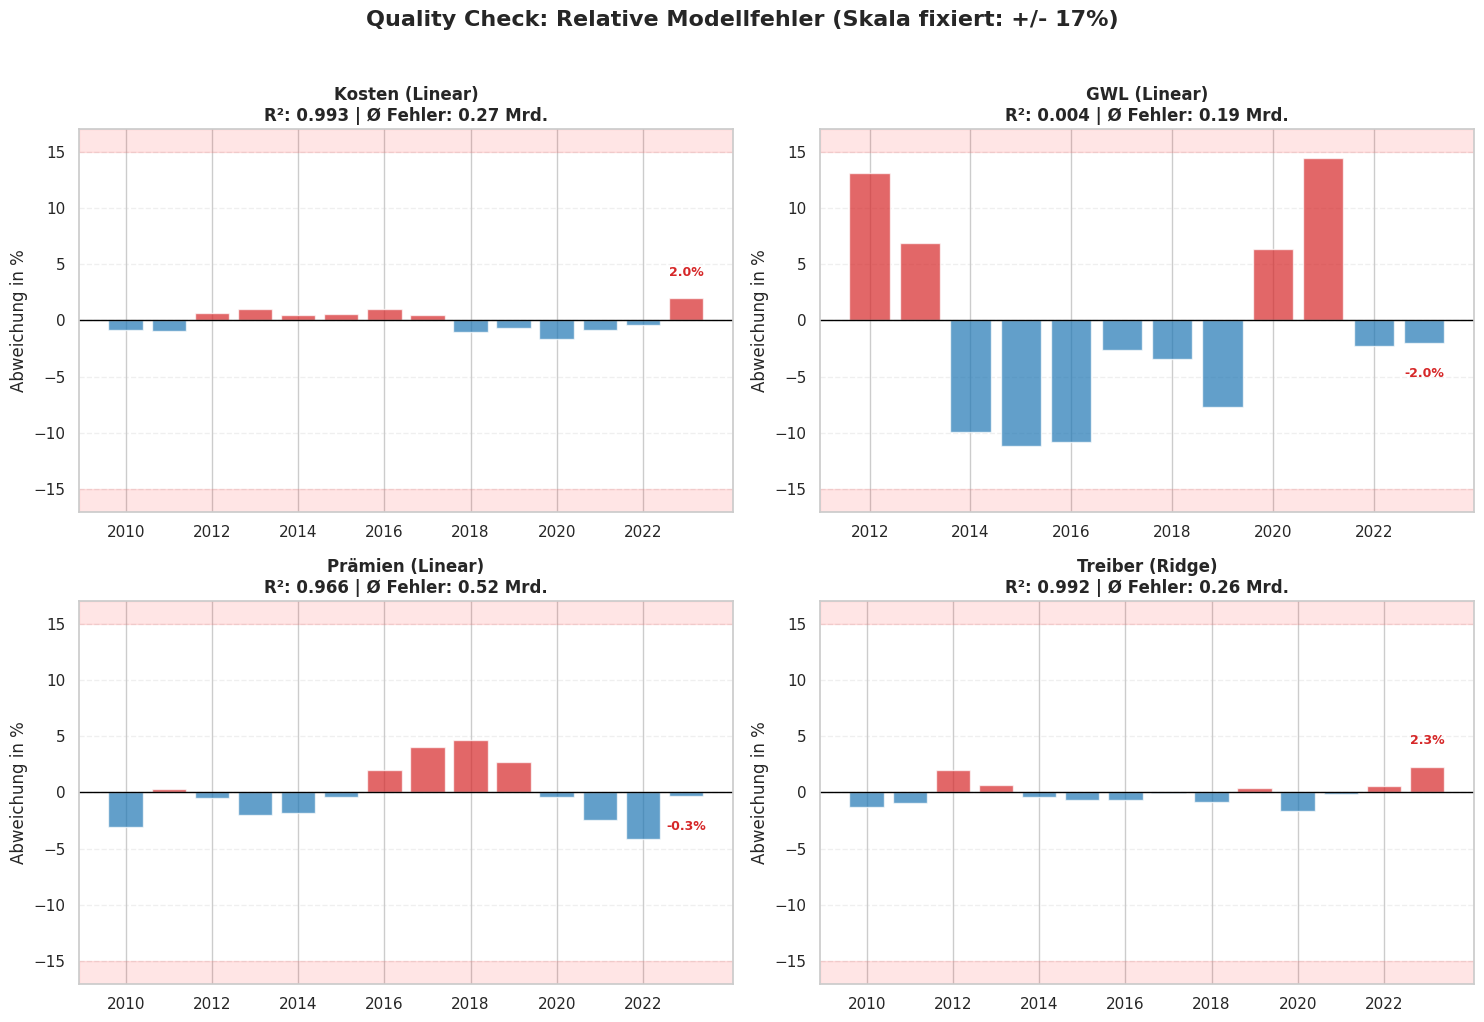

In [22]:
# ==========================================
# SCHRITT 4e: Quality Check & Validierung
# ==========================================

print("--- START QUALITY CHECK ---")

# 1. HELPER FUNCTIONS
# ------------------------------------------
cols_years = [str(y) for y in range(2010, 2024)]

def get_ts(filter_mask):
    """Extrahiert eine Zeitreihe aus df_spit basierend auf einem Filter."""
    row = df_spit[filter_mask]

    if row.empty:
        return np.zeros(len(cols_years))

    vals = row[cols_years].values[0]

    return np.array([float(str(x).replace("'", "").replace("...", "0")) for x in vals]) / 1e9

# 2. TARGETS EXTRAHIEREN
# ------------------------------------------
# Kosten Total
mask_cost = df_spit['Betriebstyp'].str.contains('Spit', na=False) & \
            df_spit['Betriebstyp'].str.contains('Total', na=False) & \
            df_spit['Aufwand und Ertrag'].str.contains('Aufwand - Total', na=False)
y_cost = get_ts(mask_cost)

# GWL (Kantonsbeiträge)
mask_gwl = df_spit['Betriebstyp'].str.contains('Spit', na=False) & \
           df_spit['Betriebstyp'].str.contains('Total', na=False) & \
           df_spit['Aufwand und Ertrag'].str.contains('Beiträge von Kantonen', na=False)
y_gwl = get_ts(mask_gwl)

# Prämien (Fallback-Logik)
if 'df_kk_clean' in locals() and not df_kk_clean.empty:
    df_kk_sorted = df_kk_clean.sort_values('Jahr')
    y_prem = df_kk_sorted[df_kk_sorted['Jahr'].between(2010, 2023)]['Praemien_M_CHF'].values / 1000
    if len(y_prem) != len(cols_years):
        y_prem = np.zeros(len(cols_years))
else:
    y_prem = np.zeros(len(cols_years))

# Personal (Ridge Features)
if 'df_per_clean' in locals() and not df_per_clean.empty:
    df_p_bridge = df_per_clean[df_per_clean['Betriebstyp'] == 'Spitäler - Total'].copy()
    ridge_cats = {'Ärzt': 'Aerzte', 'Pflege': 'Pflege', 'Administrativ': 'Admin', 'Medizinisch-technisches': 'MedTech'}

    X_ridge = pd.DataFrame(index=[int(y) for y in cols_years])

    for key_search, key_short in ridge_cats.items():
        # Suche nach Kategorie (case insensitive)
        mask_cat = df_p_bridge['Funktion'].str.contains(key_search, case=False, na=False)
        df_temp = df_p_bridge[mask_cat]

        if not df_temp.empty:
            # Summieren pro Jahr
            series = df_temp.groupby('Jahr')['Vollzeitäquivalente'].sum()
            X_ridge[key_short] = series
        else:
            X_ridge[key_short] = 0

    # Auffüllen und Filtern
    X_ridge = X_ridge.fillna(0)
    X_ridge = X_ridge.loc[[int(y) for y in cols_years]]

# ==========================================
# 3. MODELLIERUNG
# ==========================================
results = []
years_num = [int(y) for y in cols_years]
X_time = np.array(years_num).reshape(-1, 1)

# Modell 1: Kosten
if np.sum(y_cost) > 0:
    m1 = LinearRegression().fit(X_time, y_cost)
    p1 = m1.predict(X_time)
    results.append({'Name': 'Kosten (Linear)', 'y': y_cost, 'p': p1, 'years': years_num})

# Modell 2: GWL (ab 2012 für besseren Fit)
if np.sum(y_gwl) > 0:
    mask_12 = slice(2, None)
    m2 = LinearRegression().fit(X_time[mask_12], y_gwl[mask_12])
    p2 = m2.predict(X_time[mask_12])
    results.append({'Name': 'GWL (Linear)', 'y': y_gwl[mask_12], 'p': p2, 'years': years_num[2:]})

# Modell 3: Prämien
if np.sum(y_prem) > 0 and len(y_prem) == len(X_time):
    m3 = LinearRegression().fit(X_time, y_prem)
    p3 = m3.predict(X_time)
    results.append({'Name': 'Prämien (Linear)', 'y': y_prem, 'p': p3, 'years': years_num})

# Modell 4: Kostentreiber (Ridge)
if X_ridge.sum().sum() > 0 and np.sum(y_cost) > 0:
    scaler = StandardScaler()
    X_ridge_sc = scaler.fit_transform(X_ridge)
    m4 = Ridge(alpha=1.0).fit(X_ridge_sc, y_cost)
    p4 = m4.predict(X_ridge_sc)
    results.append({'Name': 'Treiber (Ridge)', 'y': y_cost, 'p': p4, 'years': years_num})

# ==========================================
# 4. VISUALISIERUNG
# ==========================================
if len(results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, res in enumerate(results):
        ax = axes[i]
        y_true = res['y']
        y_pred = res['p']
        years = res['years']

        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)

        # Berechnung in Prozent
        # Schutz vor Division durch Null
        with np.errstate(divide='ignore', invalid='ignore'):
            resid_pct = (y_true - y_pred) / y_true * 100
        resid_pct = np.nan_to_num(resid_pct) # Nans zu 0

        colors = ['#d62728' if r > 0 else '#1f77b4' for r in resid_pct]

        ax.bar(years, resid_pct, color=colors, alpha=0.7)
        ax.axhline(0, color='black', linewidth=1)

        ax.set_title(f"{res['Name']}\nR²: {r2:.3f} | Ø Fehler: {mae:.2f} Mrd.", fontweight='bold')
        ax.set_ylabel("Abweichung in %")
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.set_xticks(years[::2])

        # Fixierte Y-Achse
        ax.set_ylim(-17, 17)
        ax.axhspan(15, 17, color='red', alpha=0.1)
        ax.axhspan(-17, -15, color='red', alpha=0.1)

        # 2023 Label
        if 2023 in years:
            try:
                idx = list(years).index(2023)
                val = resid_pct[idx]
                y_pos = val + 2 if val > 0 else val - 3
                ax.text(2023, y_pos, f"{val:.1f}%", ha='center', color='#d62728', fontweight='bold', fontsize=9)
            except: pass

    # Leere Subplots ausblenden
    for j in range(len(results), 4):
        fig.delaxes(axes[j])

    plt.suptitle("Quality Check: Relative Modellfehler (Skala fixiert: +/- 17%)", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Keine Modelle berechnet. Prüfen Sie die Daten in 'df_spit'.")

#### Analyse der Modellgüte: Kosten vs. Finanzierung

Die Validierung zeigt eine signifikante Diskrepanz in der Prognostizierbarkeit der verschiedenen Finanzströme:

1.  **Hohe Prognosegüte bei Kosten & Prämien ($R^2 > 0.95$):**
    Die Modelle weisen nur geringe Abweichungen auf. Dies deutet darauf hin, dass die Kostenentwicklung und die Prämienanpassungen stabilen, linearen Trends folgen und somit verlässlich planbar sind.

2.  **Eingeschränkte Prognostizierbarkeit der GWL ($R^2 \approx 0.004$):**
    Das Modell für die gemeinwirtschaftlichen Leistungen (GWL) zeigt deutlich höhere Volatilität (Abweichungen bis zu 14%).
    **Interpretation:** Die staatlichen Beiträge folgen keinem organischen Wachstumstrend, sondern unterliegen diskretionären politischen Budgetentscheidungen. Dies führt zu Sprüngen in der Zeitreihe, die rein statistisch schwerer zu modellieren sind.

**Strategische Implikation:**
Für das Spitalmanagement bedeutet dies eine **Asymmetrie im Planungsrisiko**: Während die Ausgabenseite (Kosten) einem stetigen Aufwärtstrend folgt, ist die staatliche Finanzierungsseite (GWL) volatiler und schwieriger zu antizipieren. Dies erfordert erhöhte Liquiditätsreserven, um mögliche Schwankungen bei den Staatsbeiträgen abzufedern.

### Schritt 5: From Data to Decisions – Strategisches Fazit

**Thema:** Umgang mit asymmetrischen Finanzierungsrisiken & strukturellem Wandel

Die datengestützte Analyse der Jahre 2010–2023 und die Prognosen bis 2030 offenbaren eine doppelte Herausforderung: Die Schere zwischen Kosten und Basisfinanzierung öffnet sich, während sich die Kostenstruktur intern massiv verschiebt.

#### 1. Die Diagnose (Status Quo & ML-Erkenntnisse)
* **Kostenstruktur (Die "Treiber-Erkenntnis"):** Die Ridge-Regression bestätigt mit extrem hoher Signifikanz ($R^2 \approx 99.7\%$), dass die Personalkosten die Gesamtkosten fast vollständig erklären. Doch die Analyse zeigt ein differenziertes Bild:
    * *Der Haupttreiber:* Nicht die Pflege am Bett (+31%), sondern die **Spezialisierung (Therapie +67%)** und die **Bürokratisierung (Administration +56%)** sind die Wachstumsmotoren.
* **Finanzierungs-Asymmetrie:** Während diese Kostenblöcke einem stabilen, linearen Wachstumspfad folgen, zeigt die Analyse der staatlichen Beiträge (GWL) eine hohe Volatilität. Die Basisfinanzierung wächst nicht synchron zur Komplexität der Leistungen.
* **Konsequenz:** Das System leidet unter einer strukturellen Unterdeckung bei gleichzeitig steigender administrativer Last.

#### 2. Die Prognose (Szenario 2030)
Unter Annahme gleichbleibender Rahmenbedingungen zeigen unsere Modelle:
* Die Gesamtkosten werden voraussichtlich im Jahr **2028** die Schwelle von **40 Milliarden CHF** durchbrechen.
* Das Kostenniveau von 2023 ist kein temporärer Effekt ("Nachholbedarf"), sondern durch den Personalstock in Verwaltung und Therapie zementiert ("New Normal").

#### 3. Handlungsempfehlungen für das Management
Um die finanzielle Stabilität langfristig zu sichern, müssen die Massnahmen präziser ansetzen als bisher:

**A. Stärkung der finanziellen Resilienz**
Aufgrund der Diskrepanz zwischen stetigen Personalkosten und volatilen staatlichen Beiträgen müssen Liquiditätsreserven erhöht werden.
* *Strategie:* Budgetierung konservativer gestalten und Investitionen stärker aus dem operativen Cashflow (EBITDA) finanzieren, um die Abhängigkeit von politischen Schwankungen zu reduzieren.

**B. "Smarte" Effizienz statt "Rasenmäher-Methode"**
Die ML-Analyse beweist: Ein pauschaler Einstellungsstopp würde die Pflege treffen, obwohl diese nicht der Kostentreiber ist.
* *Strategie:* Fokus auf **Entbürokratisierung**. Das administrative Personal wächst fast doppelt so schnell wie die Pflege – hier liegt das Effizienzpotenzial (Digitalisierung).
* *Review:* Überprüfung der Anreizstrukturen im Therapie-Bereich (+67% Wachstum). Sind alle Leistungen medizinisch indiziert oder systemisch getrieben?

**C. Datengestützte Verhandlungsführung**
Die Analyse belegt, dass die Kostenexplosion durch eine **Komplexitätssteigerung** (mehr Therapie/Admin) getrieben ist, die in den pauschalen Tarifen oft nicht abgebildet ist.
* *Strategie:* Nutzung der validierten Daten ("Bürokratiekosten vs. Pflegeleistung"), um in Leistungsvereinbarungen mit den Kantonen objektivierbare Fakten für eine Anpassung der GWL vorzulegen.

In [23]:
print("--- MANAGEMENT FACTSHEET ---")

# 1. Daten aggregieren
try:
    # CAGR calculation
    n_years = len(y_cost) - 1
    cagr_cost = ((y_cost[-1] / y_cost[0])**(1/n_years) - 1) * 100

    if hasattr(m1.coef_, "__len__"):
        # If it's a list/array (e.g., [[0.5]] or [0.5])
        slope = m1.coef_[0][0] if hasattr(m1.coef_[0], "__len__") else m1.coef_[0]
    else:
        # If it's just a number
        slope = m1.coef_

    # Extract Intercept
    if hasattr(m1.intercept_, "__len__"):
         intercept = m1.intercept_[0]
    else:
         intercept = m1.intercept_

    # Prognose 2030
    forecast_2030 = slope * 2030 + intercept

    # Ridge Score & GWL Error
    ridge_score = r2_score(y_cost, p4) if 'p4' in locals() else 0.0

    # Calculate GWL error
    if 'p2' in locals() and 'y_gwl' in locals():
        gwl_error = np.max(np.abs((y_gwl[mask_12] - p2) / y_gwl[mask_12] * 100))
    else:
        gwl_error = 0.0

    # 2. Factsheet erstellen
    data = {
        'KPI / Metrik': [
            'Kosten-Trend (CAGR)',
            'Prognose-Horizont 2030',
            'Haupttreiber (Personal)',
            'Staatl. Finanzierung (GWL)',
            'Planungs-Risiko'
        ],
        'Wert': [
            f"+{cagr_cost:.1f}% pro Jahr",
            f"~ {forecast_2030:.1f} Mrd. CHF",
            f"R² = {ridge_score:.3f} (Sehr hoch)",
            f"Volatilität: +/- {gwl_error:.1f}%",
            "HOCH"
        ],
        'Strategische Implikation': [
            'Stetiges, lineares Wachstum erfordert Effizienz.',
            '40 Mrd. Grenze fällt voraussichtlich 2028.',
            'Personalbestand ist der effektivste Steuerungshebel.',
            'Kein verlässlicher Automatismus. Puffer nötig.',
            'Asymmetrie zwischen fixen Kosten & volatilen Erträgen.'
        ]
    }

    df_summary = pd.DataFrame(data)

    # 3. Output
    print("--- FINAL MANAGEMENT SUMMARY ---")
    try:
        display(df_summary)
    except NameError:
        print(df_summary.to_string(index=False))

except Exception as e:
    import traceback
    print(f"❌ Error generating Factsheet: {e}")
    traceback.print_exc()

--- MANAGEMENT FACTSHEET ---
--- FINAL MANAGEMENT SUMMARY ---


,KPI / Metrik,Wert,Strategische Implikation
0,Kosten-Trend (CAGR),+3.4% pro Jahr,"Stetiges, lineares Wachstum erfordert Effizienz."
1,Prognose-Horizont 2030,~ 41.8 Mrd. CHF,40 Mrd. Grenze fällt voraussichtlich 2028.
2,Haupttreiber (Personal),R² = 0.992 (Sehr hoch),Personalbestand ist der effektivste Steuerungs...
3,Staatl. Finanzierung (GWL),Volatilität: +/- 14.4%,Kein verlässlicher Automatismus. Puffer nötig.
4,Planungs-Risiko,HOCH,Asymmetrie zwischen fixen Kosten & volatilen E...


### 6. Quellenverzeichnis & Referenzen

Die vorliegende Analyse stützt sich auf öffentliche, validierte Datenquellen der Schweizerischen Eidgenossenschaft sowie etablierte methodische Frameworks.

#### A. Datengrundlage (Data Sources)
Alle verwendeten Datensätze stammen aus den offiziellen Statistikportalen des Bundesamtes für Statistik (BFS) und des Bundesamtes für Gesundheit (BAG).

| Datensatz (CSV) | Offizielle Bezeichnung | Quelle | Inhalt |
| :--- | :--- | :--- | :--- |
| `finanzen_spitale.csv` | **Finanzstatistik der Spitäler** | BFS | Betriebsaufwand, Erträge, Defizite und staatliche Beiträge (GWL). |
| `infrastruktur.csv` | **Medizinische Statistik der Krankenhäuser** | BFS | Pflegetage, Anzahl Betten, Austritte und Betriebsdaten. |
| `personal.csv` | **Krankenhausstatistik (Personal)** | BFS | Personalbestand in Vollzeitäquivalenten (FTE) nach Berufsgruppen. |
| `krankenkasse_clean.csv` | **Prämienstatistik der OKP** | BAG / BFS | Entwicklung der mittleren Monatsprämien (KVG) über alle Kantone. |
| `finanzierung_....csv` | **Kosten und Finanzierung des Gesundheitswesens** | BFS | Makroökonomische Daten zu Finanzierungsströmen (Staatsquote vs. Private). |

*Datenstand der Analyse: Dezember 2024 (Zeitreihen 2010-2023).*

#### B. Methodik & Tools
* **Framework:** "From Data to Decisions" (Analytics Framework für datengestützte Entscheidungsfindung).
* **Modellierung:** Python (Scikit-Learn) für Lineare Regression (OLS) und Ridge-Regularisierung ($L_2$).
* **Validierung:** CPA-Standard "Professional Skepticism" (Prüfung von $R^2$, MAE und Residuen).
